<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>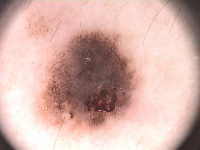</td><td>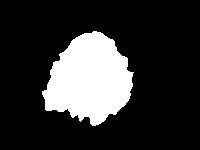</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=fda5271c-1112-4a28-bed2-fa243d7b3816
To: /content/PH2Dataset.rar
100% 162M/162M [00:00<00:00, 206MB/s]


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [11]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [12]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [13]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

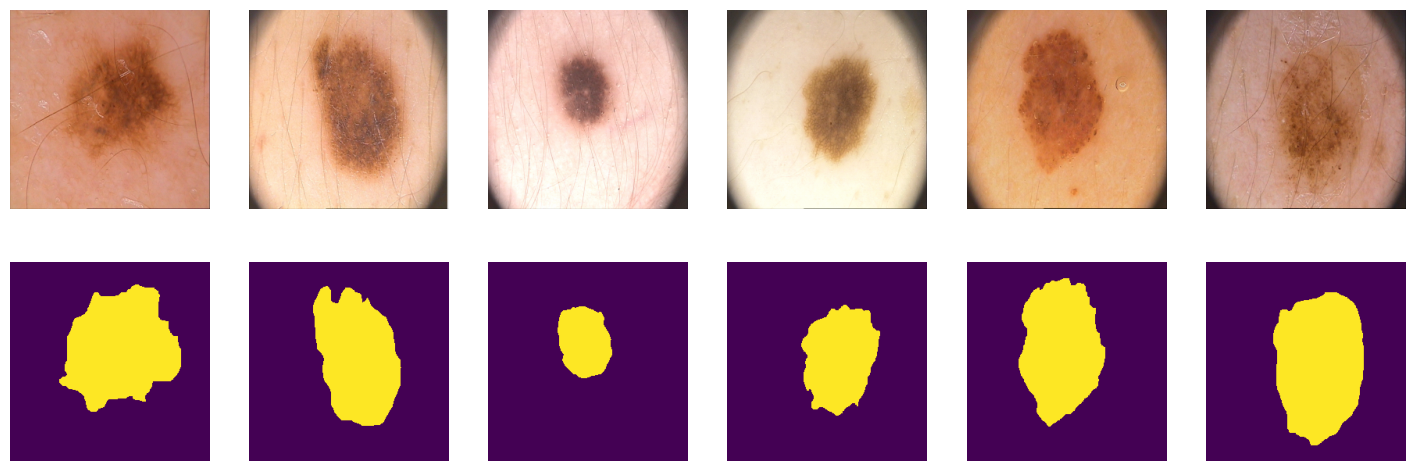

In [14]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [15]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [16]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [17]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

Исходная формула бинарной кросс-энтропии:

$$
\mathcal{L}_{BCE}(y, \hat{y}) = -\sum_i \left[ y_i \log \sigma(\hat{y}_i) + (1 - y_i) \log(1 - \sigma(\hat{y}_i)) \right]
$$

$$
\sigma(\hat{y}_i) = \frac{1}{1 + e^{-\hat{y}_i}}, \quad 1 - \sigma(\hat{y}_i) = \frac{e^{-\hat{y}_i}}{1 + e^{-\hat{y}_i}}
$$

Подставляем:

$$
\mathcal{L}_{BCE}(y, \hat{y}) = -\sum_i \left[ y_i \log \left( \frac{1}{1 + e^{-\hat{y}_i}} \right) + (1 - y_i) \log \left( \frac{e^{-\hat{y}_i}}{1 + e^{-\hat{y}_i}} \right) \right]
$$


Используем свойства логарифмов:

$$
\log \left( \frac{1}{1 + e^{-\hat{y}_i}} \right) = -\log(1 + e^{-\hat{y}_i})
$$

$$
\log \left( \frac{e^{-\hat{y}_i}}{1 + e^{-\hat{y}_i}} \right) = -\hat{y}_i - \log(1 + e^{-\hat{y}_i})
$$

Подставляем обратно:

$$
\mathcal{L}_{BCE}(y, \hat{y}) = -\sum_i \left[ y_i (-\log(1 + e^{-\hat{y}_i})) + (1 - y_i) (-\hat{y}_i - \log(1 + e^{-\hat{y}_i})) \right]
$$

Раскрываем скобки:

$$
= \sum_i \left[ y_i \log(1 + e^{-\hat{y}_i}) + (1 - y_i) \hat{y}_i + (1 - y_i) \log(1 + e^{-\hat{y}_i}) \right]
$$

Вынесем $$(log(1 + e^{-\hat{y}_i})$$

$$
= \sum_i \left[ (y_i + 1 - y_i) \log(1 + e^{-\hat{y}_i}) + (1 - y_i) \hat{y}_i \right]
$$

Упрощаем:

$$
= \sum_i \left[ \log(1 + e^{-\hat{y}_i}) + (1 - y_i) \hat{y}_i \right]
$$

Раскрываем $$(1 - y_i) \hat{y}_i$$

$$
= \sum_i \left[ \hat{y}_i - y_i \hat{y}_i + \log(1 + e^{-\hat{y}_i}) \right]
$$


**Итоговая формула:**

$$
\mathcal{L}_{BCE}(y, \hat{y}) = \hat{y}_i - y_i \hat{y}_i + \log(1 + e^{-\hat{y}_i})
$$

Для одного элемента (без суммы):

$$
\mathcal{L}_{BCE} = \hat{y} - y \hat{y} + \log(1 + \exp(-\hat{y}))
$$

Это соответствует формуле [2], что и требовалось доказать.

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_true(y_pred, y_real):
    y_pred_sigmoid = torch.sigmoid(y_pred)
    loss = - (y_real * torch.log(y_pred_sigmoid + 1e-9) + (1 - y_real) * torch.log(1 - y_pred_sigmoid + 1e-9))
    return loss.sum()

def bce_loss(y_pred, y_real):
    loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.sum()

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 4.629325866699219
BCE loss честно посчитанный = 4.629325866699219
BCE loss from torch bce_torch = 4.629325866699219
BCE loss from torch with logits bce_torch = 4.629325866699219


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 11.256234169006348
BCE loss честно посчитанный = 11.256234169006348
BCE loss from torch bce_torch = 11.256234169006348
BCE loss from torch with logits bce_torch = 11.256234169006348


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 3.85MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 4.38MB/s]
Download completed


In [ ]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

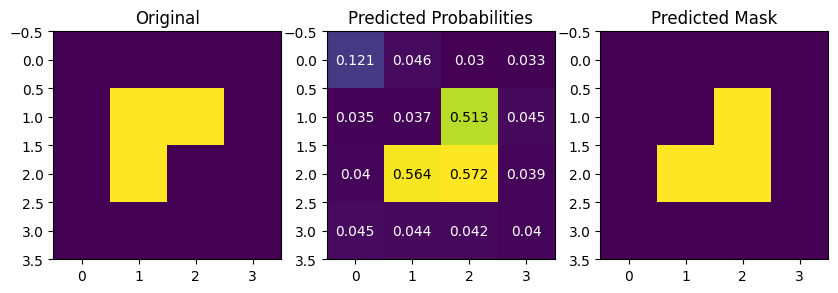

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

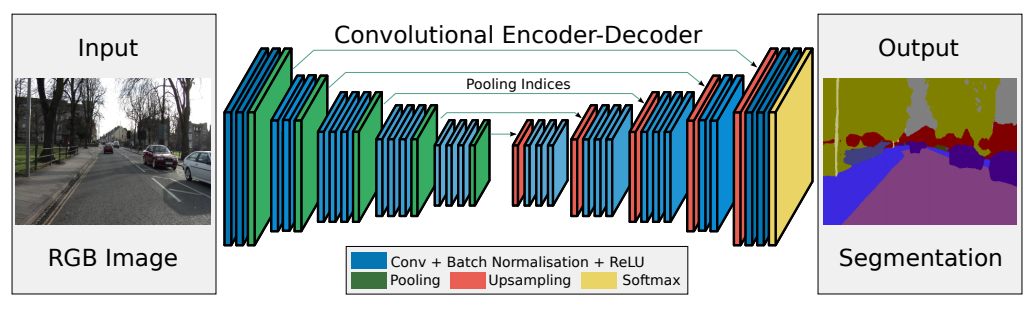

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # VGG-16 architecture
        self.encoder_block1 = self._make_enc_block(in_channels, 64)
        self.encoder_block2 = self._make_enc_block(64, 128)
        self.encoder_block3 = self._make_enc_block(128, 256, num_convs=3)
        self.encoder_block4 = self._make_enc_block(256, 512, num_convs=3)
        self.encoder_block5 = self._make_enc_block(512, 512, num_convs=3)

        # bottleneck
        self.bottleneck = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.decoder_block5 = self._make_dec_block(512, 512, num_convs=3)
        self.decoder_block4 = self._make_dec_block(512, 256, num_convs=3)
        self.decoder_block3 = self._make_dec_block(256, 128, num_convs=3)
        self.decoder_block2 = self._make_dec_block(128, 64)
        self.decoder_block1 = self._make_dec_block(64, out_channels, is_last=True)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)


    def _make_enc_block(self, in_c, out_c, num_convs=2):
        layers = []
        for i in range(num_convs):
            layers.append(nn.Conv2d(in_c if i == 0 else out_c, out_c, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def _make_dec_block(self, in_c, out_c, num_convs=2, is_last=False):
        layers = []
        for i in range(num_convs):
            layers.append(nn.Conv2d(in_c if i == 0 else out_c, out_c, kernel_size=3, padding=1))
            if not is_last:
                layers.append(nn.BatchNorm2d(out_c))
                layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        indices = []
        sizes = []

        # encoder
        x = self.encoder_block1(x)
        sizes.append(x.size())
        x, idx1 = self.pool(x)
        indices.append(idx1)

        x = self.encoder_block2(x)
        sizes.append(x.size())
        x, idx2 = self.pool(x)
        indices.append(idx2)

        x = self.encoder_block3(x)
        sizes.append(x.size())
        x, idx3 = self.pool(x)
        indices.append(idx3)

        x = self.encoder_block4(x)
        sizes.append(x.size())
        x, idx4 = self.pool(x)
        indices.append(idx4)

        x = self.encoder_block5(x)
        sizes.append(x.size())
        x, idx5 = self.pool(x)
        indices.append(idx5)

        # bottleneck
        x = self.bottleneck(x)

        # decoder
        x = self.unpool(x, indices.pop(), output_size=sizes.pop())
        x = self.decoder_block5(x)

        x = self.unpool(x, indices.pop(), output_size=sizes.pop())
        x = self.decoder_block4(x)

        x = self.unpool(x, indices.pop(), output_size=sizes.pop())
        x = self.decoder_block3(x)

        x = self.unpool(x, indices.pop(), output_size=sizes.pop())
        x = self.decoder_block2(x)

        x = self.unpool(x, indices.pop(), output_size=sizes.pop())
        x = self.decoder_block1(x)

        return x # no activation

In [ ]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train(model, train_loader, valid_loader, optimizer, loss_fn, metric_fn, epochs=10, device='cuda'):
    best_iou = 0.0
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        metric_fn.reset()

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for x_batch, y_batch in pbar:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float32), y_batch.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.sigmoid(outputs)
            metric_fn.update(preds, y_batch.int())

        train_iou = metric_fn.compute().item()
        print(f"[Epoch {epoch+1}] Train Loss: {running_loss:.4f}, Train IoU: {train_iou:.4f}")

        # VALIDATION
        model.eval()
        val_loss = 0.0
        metric_fn.reset()
        with torch.no_grad():
            for x_batch, y_batch in valid_loader:
                x_batch, y_batch = x_batch.to(device, dtype=torch.float32), y_batch.to(device, dtype=torch.float32)
                outputs = model(x_batch)
                loss = loss_fn(outputs, y_batch)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                metric_fn.update(preds, y_batch.int())

        val_iou = metric_fn.compute().item()
        print(f"[Epoch {epoch+1}] Valid Loss: {val_loss:.4f}, Valid IoU: {val_iou:.4f}\n")
        if epoch == 0 or val_iou > best_iou:
          best_iou = val_iou
          torch.save(model.state_dict(), "best_segnet.pt")
          print("✅ Saved best model.")

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
epochs = 10

train(
    model=segnet_model,
    train_loader=train_dataloader,
    valid_loader=valid_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    metric_fn=iou_score,
    epochs=epochs,
    device=device
)

Epoch 1/10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 2.7217, Train IoU: 0.1478
[Epoch 1] Valid Loss: 1.3531, Valid IoU: 0.0000

✅ Saved best model.


Epoch 2/10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 2.5783, Train IoU: 0.1363
[Epoch 2] Valid Loss: 1.3828, Valid IoU: 0.0273

✅ Saved best model.


Epoch 3/10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 2.4689, Train IoU: 0.2199
[Epoch 3] Valid Loss: 1.4271, Valid IoU: 0.0574

✅ Saved best model.


Epoch 4/10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 2.1254, Train IoU: 0.4466
[Epoch 4] Valid Loss: 5.3001, Valid IoU: 0.2697

✅ Saved best model.


Epoch 5/10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 1.7390, Train IoU: 0.6258
[Epoch 5] Valid Loss: 2.7843, Valid IoU: 0.4951

✅ Saved best model.


Epoch 6/10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 1.4715, Train IoU: 0.6807
[Epoch 6] Valid Loss: 9.2288, Valid IoU: 0.4431



Epoch 7/10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 1.3230, Train IoU: 0.6777
[Epoch 7] Valid Loss: 0.9455, Valid IoU: 0.6044

✅ Saved best model.


Epoch 8/10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 8] Train Loss: 1.1113, Train IoU: 0.7241
[Epoch 8] Valid Loss: 0.8446, Valid IoU: 0.5896



Epoch 9/10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 9] Train Loss: 1.0312, Train IoU: 0.7348
[Epoch 9] Valid Loss: 0.6073, Valid IoU: 0.7055

✅ Saved best model.


Epoch 10/10 [Train]:   0%|          | 0/4 [00:00<?, ?it/s]

[Epoch 10] Train Loss: 0.9851, Train IoU: 0.7458
[Epoch 10] Valid Loss: 0.7350, Valid IoU: 0.6745



## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def test(model, test_loader, loss_fn, metric_fn, checkpoint_path, device='cuda'):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    total_loss = 0.0
    metric_fn.reset()

    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader, desc="Testing", leave=False):
            x_batch = x_batch.to(device, dtype=torch.float32)
            y_batch = y_batch.to(device, dtype=torch.float32)

            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs)
            metric_fn.update(preds, y_batch.int())

    final_iou = metric_fn.compute().item()
    print(f"Test Loss: {total_loss:.4f}, Test IoU: {final_iou:.4f}")

In [ ]:
test(
    model=segnet_model,
    test_loader=test_dataloader,
    loss_fn=nn.BCEWithLogitsLoss(reduction='mean'),
    metric_fn=iou_score,
    checkpoint_path="best_segnet.pt",
    device=device
)

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 0.6578, Test IoU: 0.6395


# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [74]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5, eps: float = 1e-8):
    '''
    Это именно метрика, не лосс.
    '''
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    intersection = (preds * labels).sum()
    denominator = preds.sum() + labels.sum()

    return (2.0 * intersection + eps) / (denominator + eps)

Проверим на корректность функцию dice_score:

In [79]:
from torchmetrics.segmentation import DiceScore
dice = DiceScore(average='micro', num_classes=1).to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.4244)

In [80]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

AssertionError: 

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [93]:
def dice_loss(outputs, labels, smooth=1e-5):
    outputs = torch.sigmoid(outputs)

    outputs_flat = outputs.view(-1)
    labels_flat = labels.view(-1)

    intersection = torch.sum(outputs_flat * labels_flat)
    union = torch.sum(outputs_flat) + torch.sum(labels_flat)

    dice_loss = 1 - (2 * intersection + smooth) / (union + smooth)

    return dice_loss

Проверка на корректность:

In [85]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [94]:
from monai.losses import DiceLoss
dice_loss_torch = DiceLoss(sigmoid=True)
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756)

In [95]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [102]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # TODO

    return loss

Проверка корректности функции:

In [103]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161)

In [104]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

NameError: name 'loss' is not defined

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

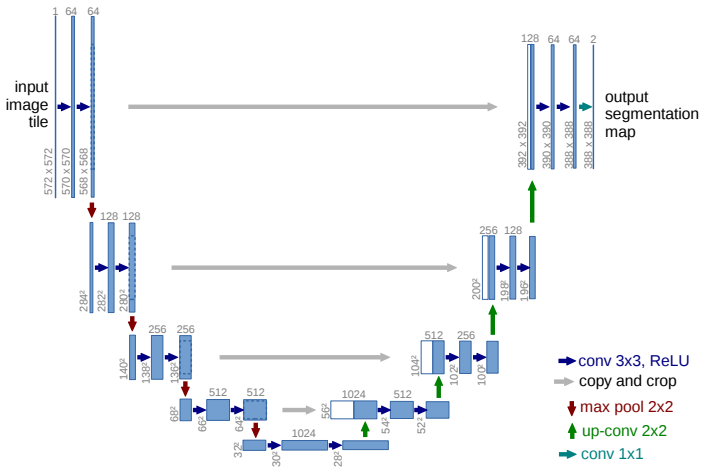

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [1]:
import torch.nn.functional as F
import torch.nn as nn

In [2]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # Энкодер (схлопывающий путь)
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.enc3 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.enc4 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Центральная часть
        self.center = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        )

        # Декодер (расширяющий путь) с skip-соединениями
        self.dec4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        )

        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        )

        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        )

        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Выходной слой
        self.out = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
       # Проход через энкодер
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        # Центральная часть
        c = self.center(e4)

        # Проход через декодер с skip-соединениями
        d4 = self.dec4(torch.cat([c, e4], dim=1))
        d3 = self.dec3(torch.cat([d4, e3], dim=1))
        d2 = self.dec2(torch.cat([d3, e2], dim=1))
        d1 = self.dec1(torch.cat([d2, e1], dim=1))

        # Выход
        output = self.out(d1)
        return output

In [5]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [19]:
import tqdm

In [21]:
unet_model = UNet().to(device)

optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [22]:
def train(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    best_iou = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Валидация
        model.eval()
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val"):
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.float32)

                outputs = model(images)
                val_iou += dice_score(outputs, masks)  # кастомная метрика

        val_iou /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Dice: {val_iou:.4f}")

        # Сохраняем лучшую модель
        if epoch == 0 or val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), "best_unet.pt")
            print("✅ Saved best model.")

In [23]:
train(unet_model, train_dataloader, valid_dataloader, optimizer, criterion, device, epochs=10)

TypeError: 'module' object is not callable